In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ast
import itertools
import os
import pandas as pd

In [6]:
def parse_log(fn):
    with open(fn, "r") as f:
        log = f.readlines()
    log = [f.rstrip() for f in log]
    mark_idx = []
    for idx, l in enumerate(log):
        if 'iter ' in l or 'stopping criterion' in l:
            mark_idx.append(idx)

    run_time = []
    for idx in mark_idx[1:]:
        run_time.append(ast.literal_eval(log[idx-1].split(" ")[-1][:-1]))

    optimal_Is = []
    optimal_quantizers = []
    optimal_dists = []
    for i, _ in enumerate(mark_idx[:-1]):
        mark_idx_input = []
        for idx, line in enumerate(log[mark_idx[i]:mark_idx[i+1]]):
            if "given input" in line:
                mark_idx_input.append(idx)
            if "optimal quantizer" in line:
                mark_idx_input.append(idx)
            if "optimal input distribution" in line:
                mark_idx_input.append(idx)
            if "optimal I" in line:
                mark_idx_input.append(idx)
        optimal_Is.append(ast.literal_eval(log[mark_idx[i]:mark_idx[i+1]][mark_idx_input[-1]].split(" ")[-1]))
        
        optimal_quantizer = "".join(log[mark_idx[i]:mark_idx[i+1]][mark_idx_input[1]:mark_idx_input[2]]).split(" [")[-1]
        optimal_quantizer = optimal_quantizer.split("]")[0].strip().split(" ")
        optimal_quantizer = filter(lambda x: x != '', optimal_quantizer)
        optimal_quantizer = np.array([ast.literal_eval(x) for x in optimal_quantizer])
        optimal_quantizers.append(optimal_quantizer)

        optimal_dist = "".join(log[mark_idx[i]:mark_idx[i+1]][mark_idx_input[2]:mark_idx_input[3]]).split(" [")[-1]
        optimal_dist = optimal_dist.split("]")[0].strip().split(" ")
        optimal_dist = filter(lambda x: x != '', optimal_dist)
        optimal_dist = np.array([ast.literal_eval(x) for x in optimal_dist])
        optimal_dists.append(optimal_dist)
    
    return len(run_time), run_time, optimal_quantizers, optimal_dists, optimal_Is

Test

In [149]:
# fn = './logs/3_levels/mode3.sigma1.seed301554.time1672258071.log'
parse_log(fn)

(2,
 [37.0786, 37.7508],
 array([-8.  , -1.36,  1.36,  8.  ]),
 array([0.38174668, 0.23650665, 0.38174667]),
 [1.1318035933560924, 1.1318035933560924])

Run

In [91]:
level = 5
# root_path = "./logs/old/{}_levels/".format(level)
root_path = "./logs/{}_levels/".format(level)
files = os.listdir(root_path)
files = [root_path + f for f in files if f.endswith(".log") and 'mode4' not in f]

In [92]:
data_parse = {}

for fn in files:
    key = fn.split("/")[-1].split(".")[-2]
    data_parse[key] = parse_log(fn)
    
df = pd.DataFrame(data_parse).T.reset_index()
df.columns = ["file", "num_iter", "run_time_iter", "opt_thres", "opt_dist", "opt_I"]
df["run_time_iter_cumsum"] = df["run_time_iter"].apply(lambda x: np.cumsum(x))
df["max_opt_I"] = df["opt_I"].apply(lambda x: np.max(x))
max_opt_I = np.max(df["max_opt_I"])
percent_max = 1 - len(df[df["max_opt_I"] < max_opt_I])/len(df)

In [94]:
df["sum_run_time_iter"] = df["run_time_iter"].apply(lambda x: sum(x))
df["sum_run_time_iter"].mean()

7.464009000000001

In [65]:
df["rt"] = df["run_time_iter"].apply(lambda x: sum(x))
# df["rt"].mean()

In [66]:
# drop 1 row due to numerical blow up, level5
df = df[df["num_iter"]!=9]

In [28]:
df.to_csv("./logs_parsed/log_parsed_{}_levels.csv".format(level))

In [6]:
# df = pd.read_csv("./logs_parsed/log_parsed_{}_levels.csv".format(level))

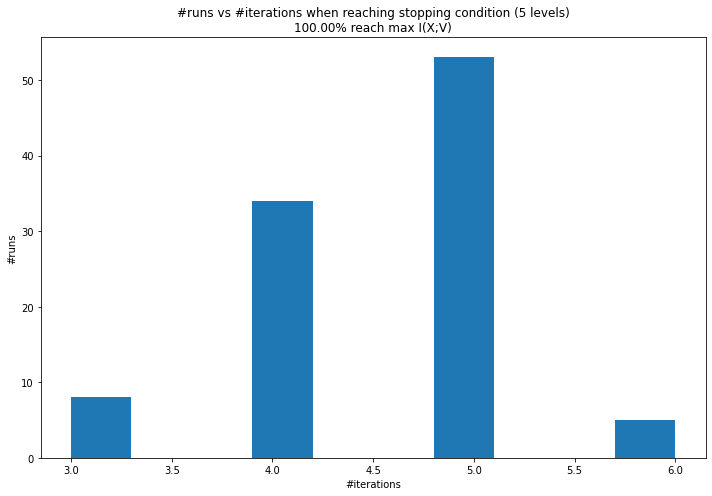

In [93]:
fig = plt.figure(figsize=(10,7))
plt.hist(df["num_iter"])
plt.ylabel("#runs")
plt.xlabel("#iterations")
plt.title("#runs vs #iterations when reaching stopping condition ({} levels)\n{:.2f}% reach max I(X;V)".format(level, 100*percent_max))
# plt.show()
plt.tight_layout()
# fig.savefig("./plots/plot_a_{}levels.png".format(level), dpi=400)

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 39., 26.]),
 array([1.13018953, 1.13031483, 1.13044012, 1.13056542, 1.13069071,
        1.13081601, 1.1309413 , 1.1310666 , 1.1311919 , 1.13131719,
        1.13144249]),
 <BarContainer object of 10 artists>)

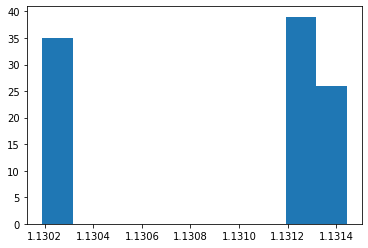

In [90]:
plt.hist(df["max_opt_I"])

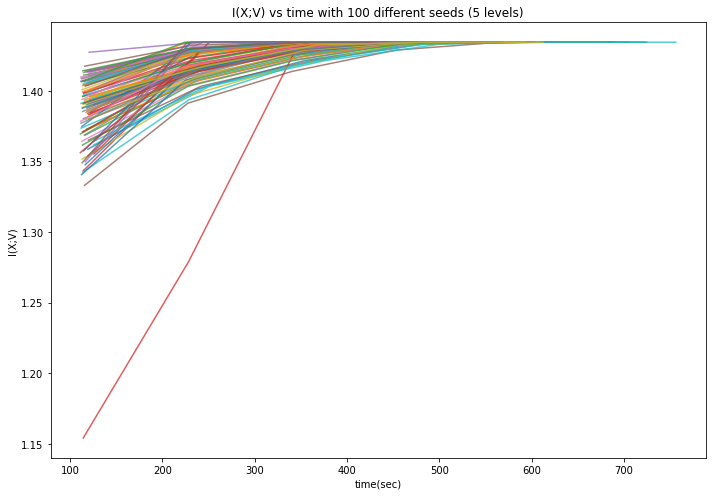

In [68]:
fig = plt.figure(figsize=(10,7))
for idx, row in df.iterrows():
    plt.plot(row["run_time_iter_cumsum"], row["opt_I"], alpha=0.75)
plt.xlabel("time(sec)")
plt.ylabel("I(X;V)")
plt.title("I(X;V) vs time with 100 different seeds ({} levels)".format(level))
# plt.show()
plt.tight_layout()
fig.savefig("./plots/plot_b_{}levels.png".format(level), dpi=400)

In [69]:
df["repeat_I"] = df["opt_I"].apply(lambda x: x + [x[-1]]*10)
df["repeat_I"] = df["repeat_I"].apply(lambda x: x[:10])

df_avg = pd.DataFrame(df["repeat_I"].to_list(), columns=["iter_{}".format(i) for i in range(10)])
avg = df_avg

df["run_time_total"] = df["run_time_iter"].apply(lambda x: sum(x))
avg_time_per_iter = df["run_time_total"].sum()/df["num_iter"].sum() 

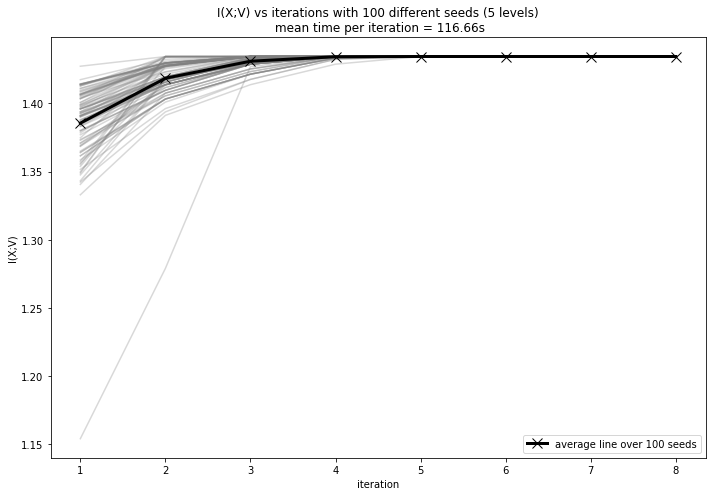

In [70]:
fig = plt.figure(figsize=(10,7))
for idx, row in df.iterrows():
    plt.plot(range(1, len(row["opt_I"])+1), row["opt_I"], color="gray", alpha=0.3)
plt.plot(range(1, 9), df_avg.agg("mean").to_list()[:8], marker="x", markersize=10, color="black", linewidth=3, label="average line over 100 seeds")
plt.xlabel("iteration")
plt.ylabel("I(X;V)")
plt.title("I(X;V) vs iterations with 100 different seeds ({} levels)\n mean time per iteration = {:.2f}s".format(level, avg_time_per_iter))
# plt.show()
plt.legend()
plt.tight_layout()
fig.savefig("./plots/plot_c_{}levels.png".format(level), dpi=400)